In [ ]:
!git clone https://github.com/khalld/deep-learning.git
!mv deep-learning dl
from google.colab import drive
drive.mount('/content/gdrive')

In [1]:
from libs.code import *
import torch
from torch.utils import data # necessary to create a map-style dataset https://pytorch.org/docs/stable/data.html
from os.path import splitext, join
from PIL import Image
import numpy as np
import pandas as pd
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch import nn
from torch.optim import SGD
import pytorch_lightning as pl
from sklearn.manifold import TSNE
from pytorch_lightning.loggers import TensorBoardLogger
import random
from random import choice

np.random.seed(1996)
torch.manual_seed(1996)
random.seed(1996)

In [2]:
PATH_DST = join('dataset', 'all_labels.csv')
PATH_GDRIVE = ''
NUM_WORKERS = 6 # vecchio progetto 2 ma il pc è più potente
BATCH_SIZE = 32 # come nel vecchio progetto
NUM_EPOCHS = 5
GPUS = 0

# mean and dev std of MNIST
mean = 0.1307
std = 0.3081

dataset_df = pd.read_csv(join(PATH_GDRIVE, PATH_DST))

dic_dst = {
    0: 'empty',
    1: 'half',
    2: 'full'
}

In [3]:
%reload_ext tensorboard
%tensorboard --logdir metric_logs

Reusing TensorBoard on port 6006 (pid 3407), started 1:11:04 ago. (Use '!kill 3407' to kill it.)

## Deep Autoencoders - Extract codes

In [ ]:
# TODO: .....

## Metric Learning

In [4]:
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=1), #TODO: immagini in bianco e nero x semplificare e farlo uguale al prof
                                transforms.Resize((28,28)),  # # 256 x 256 nel vecchio progetto
                                transforms.ToTensor(),
                                transforms.Normalize((mean,),(std)),
                                ])

dataset_triplet = TripletTrashbin(root=PATH_DST, transform=transform)

# ***** Visualizzo la rete triplet implmentata ***** TODO: fai meglio



***** Start making triplets... *****
Triplets process ended


Visualizzo il dataset adattato al task:

In [ ]:
# TODO: FIXA!!! Si vede malissimo
plt.figure(figsize=(18,4))
for ii, i in enumerate(np.random.choice(range(len(dataset_triplet)), 3)):
    plt.subplot(3, 10, ii+1)
    # plt.text(3,10, 'Main element %i' % (i))
    plt.imshow(dataset_triplet[i][0],)
    
    # plt.text(3,10, 'Similar to %i' % (i))
    plt.subplot(3, 10, ii+11)
    plt.imshow(dataset_triplet[i][1])

    # plt.text(3,10, 'Dissimilar to %i' % (i))
    plt.subplot(3, 10, ii+21)
    plt.imshow(dataset_triplet[i][2])
plt.show()

Carico il dataloader:

In [5]:
dataset_train_triplet, dataset_test_triplet = split_into_train_and_test(dataset_triplet)

dataset_train_loader_triplet = DataLoader(dataset_train_triplet, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
dataset_test_loader_triplet = DataLoader(dataset_test_triplet, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
#dataset_validation_loader = ...

Training:

In [6]:
triplet_trashbin_task = TripletNetworkTask(embedding_net=EmbeddingNet())
logger = TensorBoardLogger("metric_logs", name="siamese_triplet")
trainer = pl.Trainer(gpus=GPUS, logger=logger, max_epochs=NUM_EPOCHS, progress_bar_refresh_rate=0)
trainer.fit(triplet_trashbin_task, dataset_train_loader_triplet, dataset_test_loader_triplet)

/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | embedding_net | EmbeddingNet      | 350 K 
1 | criterion     | TripletMarginLoss | 0     
----------------------------------------------------
350 K     Trainable params
0         Non-trainable pa

In [9]:
def extract_representations_fix(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    model.to(device)
    representations, labels = [], []
    for batch in loader:
        x = batch[0].to(device)
        rep = model(x)
        rep = rep.detach().to('cpu').numpy()
        labels.append(batch[1])
        representations.append(rep)
    return np.concatenate(representations), np.concatenate(labels)

In [30]:
dataset_df = pd.read_csv(PATH_DST)
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=1), #TODO: immagini in bianco e nero x semplificare e farlo uguale al prof
                                transforms.Resize((28,28)),     # resize dell'immagine come in LAB 01 per fare i test TODO da adattare
                                transforms.ToTensor(),
                                transforms.Normalize((mean,),(std)),
                                ])

trashbin_test_loader = DataLoader(TrashbinDataset(PATH_DST, transform=transform), batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

trashbin_test_representations, trashbin_test_labels = extract_representations_fix(triplet_trashbin_task.embedding_net, trashbin_test_loader)

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/danilo/GitHub/deep-learning/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


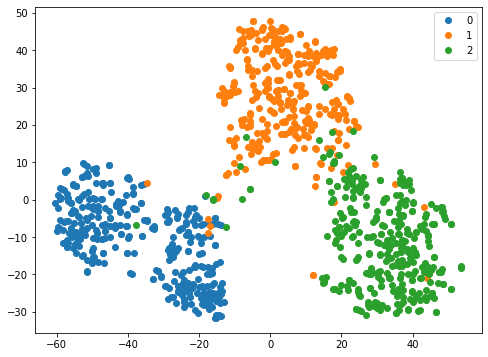

In [32]:
selected_rep = np.random.choice(len(trashbin_test_representations), 1000)
selected_tb_test_representations = trashbin_test_representations[selected_rep]
selected_tb_test_labels = trashbin_test_labels[selected_rep]

tsne = TSNE(2)
rep_tsne = tsne.fit_transform(selected_tb_test_representations)

plt.figure(figsize=(8,6))
for c in np.unique(selected_tb_test_labels):
    plt.plot(rep_tsne[selected_tb_test_labels == c, 0], rep_tsne[selected_tb_test_labels == c, 1], 'o', label=c)
plt.legend()
plt.show()